# AutoEncoder, Variational AutoEncoder and GAN

In [16]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from datetime import datetime
from utils import *

seed = 265
torch.manual_seed(seed)
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


## Introduction

In this assignment we will go through 3 types of unsupervised neural network: AutoEncoder (AE), Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN). In the first section we will also introduce a new type of layer: the transpose convolution as it is widely used in these unsupervised methods.

Unsupervised have many advantages including the fact that they don't need labels but they are also harder to train. It is normal if you don't get good results.

## Contents

1. Transpose convolution
2. AutoEncoder
3. Variational AutoEncoder
4. GAN

## Related videos from the curriculum

- [Lecture 15.1 — From PCA to autoencoders](https://www.youtube.com/watch?v=PSOt7u8u23w&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=69)
- [Lecture 15.2 — Deep autoencoders](https://www.youtube.com/watch?v=6jhhIPdgkp0&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=70) 
- [Lecture 15.3 — Deep autoencoders for document retrieval](https://www.youtube.com/watch?v=ZCNbjpcX0yg&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=71)
- [Lecture 15.6 — Shallow autoencoders for pre training](https://www.youtube.com/watch?v=xjlvVfEbhz4&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=74)
- [Lecture 13 | Generative Models](https://www.youtube.com/watch?v=5WoItGTWV54)


## 1. Transpose convolution

**NOTE:** The next sections do not depend on this section, if you are stuck here you can move on to the section 2.

--------------------

In this assignment we will use a new type of layer: Transpose Convolution. This layer is typically used when we want to use a neural network to generate images (which is the case for AE, VAE and GAN). To make sure that you understand what it does we ask you to implement a simplified version of the transpose convolution operation. 

TransposeConvolution is NOT the inverse operation of convolution! In mathematics, deconvolution is the operation inverse to convolution. But in machine learning it is often said that TransposeConvolution layers are the symmetric or the inverse of the convolution layers (which is not mathematically true).  The name comes from the fact that the transposed convolution transposes the weight matrix and the input in the actual calculation process compared to the direct convolution.

Surprisingly, Andrew did not make any video about this layer. For some ressource you can check this [blog post](https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8) or this [video](https://www.youtube.com/watch?v=QmCxqsbn5B0). 

Specifically, for an input tensor ``x`` of shape ``(N, C_in, H_in, W_in)`` and a weight tensor ``weights`` of shape ``(C_in, C_out, kernel_size[0], kernel_size[1])`` a transpose convolution layer returns  a tensor ``out`` of shape ``(N, C_out, H_out, W_out)`` (See the *shape* section of [torch.nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html?highlight=convtranspose2d#torch.nn.ConvTranspose2d) for the formula that gives ``(H_out, W_out)``)), such that:

$$out[n, \; c_{out}, \; h_{start}:h_{end}, \; w_{start}:w_{end}] = \sum_{c_{in} = 0}^{C_{in}-1} x[n, \; c_{in}, \; h, \; w] \times weights[c_{in}, \; c_{out}, \; :h_{end}-h_{start}, \; :w_{end}-w_{start}]$$

For:

- $n = 0 ... N - 1$
- $c = 0 ... C_{out} - 1$
- $h = 0 ... H_{in} - 1$
- $w = 0 ... W_{in} - 1$


With:
- $h_{start} = h*stride[0]$
- $w_{start} = w*stride[1]$
- $h_{end} = min(H_{out}, h_{start} + kernel_size[0])$
- $w_{end} = min(W_{out}, w_{start} + kernel_size[1])$

--------------------
## TODO

1. Write a ``get_output_size`` function that takes as parameter an input tensor ``x`` of shape ``(N, C_in, H_in, W_in)``, a tuple of int ``kernel_size`` and a tuple of int ``stride`` and that returns the expected output spatial shape ``(H_out, W_out)`` of the transpose convolution operation. See the *shape* section of [torch.nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html?highlight=convtranspose2d#torch.nn.ConvTranspose2d) for the formula that gives this output shape (We ignore the padding here, so ``padding=0``)

2. Write a ``apply_transpose_conv`` function that takes as parameter an input tensor ``x`` of shape ``(N, C_in, H_in, W_in)``, a weight tensor ``weights`` of shape ``(C_in, C_out, kernel_size[0], kernel_size[1])`` and a tuple of int ``stride`` and that returns ``out``, a tensor with the right shape and containing the result of the transpose convolution operation between ``x`` and ``weights``. You are of course not allowed to use [torch.nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html?highlight=convtranspose2d#torch.nn.ConvTranspose2d) not its functional counterpart. 

**NOTE:** We will not really use this function in practice so it's okay to use for loops for the sake of clarity and simplicity in this section

**NOTE:** You will be able to test your functions in the next cell.

In [17]:
def get_output_size(x, kernel_size, stride):
    (_, _, H_in, W_in) = x.shape
    stride = int_to_pair(stride)
    kernel_size = int_to_pair(kernel_size)
    H_out = (H_in - 1)*stride[0] + kernel_size[0] 
    W_out = (W_in - 1)*stride[1] + kernel_size[1]
    return (H_out, W_out)


def apply_transpose_conv(x, weights, stride):
    # stride must be pairs of int
    stride = int_to_pair(stride)

    # weights
    (_ , C_out, k_w, k_h) = weights.shape
    kernel_size = [k_w, k_h]

    # get output shape
    (N, C_in, H_in, W_in) = x.shape
    H_out, W_out = get_output_size(x, kernel_size, stride)

    # Initialize output tensor with the right shape 
    out = torch.zeros((N, C_out, H_out, W_out))

    # We will not really use this function in practice so it's okay to use 
    # for loops for the sake of clarity 
    for n in range(N):
        for c_out in range(C_out):
            for h in range(H_in):
                for w in range(W_in):

                    # Define the specific part of 'out' to update
                    h_start = h*stride[0]
                    w_start = w*stride[1]
                    h_end = min(H_out, h_start + kernel_size[0])
                    w_end = min(W_out, w_start + kernel_size[1])

                    # Multi-channel transpose convolution
                    for c_in in range(C_in):
                        out[n, c_out, h_start:h_end, w_start:w_end] += x[n, c_in, h, w] * weights[c_in, c_out, :h_end-h_start, :w_end-w_start]
    return out

### Test tranpose convolution 

In [3]:
test_transpose_conv(apply_transpose_conv)

weights shape:      torch.Size([5, 2, 3, 2])
input shape:        torch.Size([2, 5, 4, 3])
shape expected:     torch.Size([2, 2, 6, 4])
out1.shape:         torch.Size([2, 2, 6, 4])
out2.shape:         torch.Size([2, 2, 6, 4])
Relative error x1:  0.00000
Relative error x2:  0.00000


# 2. AutoEncoder

*related videos from the curriculum*

- [Lecture 15.1 — From PCA to autoencoders](https://www.youtube.com/watch?v=PSOt7u8u23w&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=69)
- [Lecture 15.2 — Deep autoencoders](https://www.youtube.com/watch?v=6jhhIPdgkp0&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=70) 
- [Lecture 15.3 — Deep autoencoders for document retrieval](https://www.youtube.com/watch?v=ZCNbjpcX0yg&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=71)
- [Lecture 15.6 — Shallow autoencoders for pre training](https://www.youtube.com/watch?v=xjlvVfEbhz4&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=74)
- [Lecture 13 | Generative Models](https://www.youtube.com/watch?v=5WoItGTWV54&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=17) (from 20:40 to 27:05)

An AutoEncoder (AE) is a neural network that is composed of 2 sub-networks: an Encoder and a Decoder. AE can have many purposes but commonly the main objective is to efficiently represent the data that lies on a non-linear manifold. From this point of view, the AutoEncoder can be seen as a generalization of PCA for data that lies on non-linear manifolds as explained in this [video](https://www.youtube.com/watch?v=PSOt7u8u23w&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=69) of the curriculum.

If this is the objective then the Decoder part can be thrown away once the training is done and we can simply use the encoder part to project the data into a latent space of lower dimension ``z_dim`` (in this section, ``z_dim`` will typically be 15 or 30 while the images are 20x20 (=400)). The Decoder is just here to make sure that the encoding is well done and ensure a faithful representation of the data by comparing the reconstructed (i.e decoded) instances of the compressed (i.e encoded) data with the original data.

### Modules 

In the cell below are defined the following modules that we will need in this section

1. **MyEncoder**
    - input: image
    - output: tensor `z` in latent space (lower dimension than input space)
1. **MyDecoder**
    - input: tensor `z` in latent space (lower dimension than image space)
    - output: reconstructed image
1. **MyAE**
    - input: image
    - output reconstructed image after reduction to latent space
    - attributes:
      - self.encoder = MyEncoder(z_dim)
      - self.decoder = MyDecoder(z_dim)
1. **MyClassifier**
    Classifier on compressed images:
    - input: tensor `z` in latent space (lower dimension than image space)
    - output: label predicted

--------------------
## TODO

1. Take a look at the ``MyEncoder``, ``MyDecoder`` and ``MyAE`` modules. Do the Encoder and Decoder seem really different from any other neural networks so far?


In [4]:
class MyEncoder(nn.Module):
    """
    Encoder module: 
    - input: image
    - output: tensor `z` in latent space (lower dimension than input space)
    """

    def __init__(self, z_dim):
        super().__init__() 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=6, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=5, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=5, out_channels=4, kernel_size=4, stride=1)
        self.fc3 = nn.Linear(in_features=256, out_features=z_dim)
        
    def forward(self, x):
        N = x.shape[0]
        out = torch.relu(self.conv1(x))
        out = torch.relu(self.conv2(out))
        out = torch.relu(self.conv3(out))
        out = out.view(N, -1)
        out = torch.relu(self.fc3(out))
        return out

class MyDecoder(nn.Module):
    """
    Decoder module: 
    - input: tensor `z` in latent space (lower dimension than image space)
    - output: reconstructed image
    """
    def __init__(self, z_dim):
        super().__init__() 
        c1 = 3
        self.fc1 = nn.Linear(z_dim, 128)
        self.fc2 = nn.Linear(128, 18*18)
        self.transconv3 = nn.ConvTranspose2d(in_channels=1, out_channels=1,  kernel_size=3, stride=1)
        
        
    def forward(self, x):
        N, z_dim = x.shape
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = out.view(N, 1, 18, 18)
        out = torch.sigmoid(self.transconv3(out))
        return out

class MyAE(nn.Module):
    """
    AutoEncoder
    - input: image
    - output reconstructed image after reduction to latent space

    attributes
    - self.encoder = MyEncoder(z_dim)
    - self.decoder = MyDecoder(z_dim)
    """

    def __init__(self, z_dim):
        super().__init__() 
        self.encoder = MyEncoder(z_dim)
        self.decoder = MyDecoder(z_dim)
        
    def forward(self, x):
        self.z = self.encoder(x)
        out = self.decoder(self.z)
        return out

class MyClassifier(nn.Module):
    """
    Classifier on compressed images:
    - input: tensor `z` in latent space (lower dimension than image space)
    - output: label predicted
    """

    def __init__(self, z_dim, n_labels=10):
        super().__init__() 
        c1 = 12
        self.fc1 = nn.Linear(z_dim, 64)
        self.transconv1 = nn.ConvTranspose2d(in_channels=1,  out_channels=c1, kernel_size=3, stride=1)
        self.transconv2 = nn.ConvTranspose2d(in_channels=c1, out_channels=1,  kernel_size=3, stride=1)
        self.fc2 = nn.Linear(144, n_labels)
        
    def forward(self, x):
        N, z_dim = x.shape
        out = F.relu(self.fc1(x))
        out = out.view(N, 1, 8, 8)
        out = F.relu(self.transconv1(out)) 
        out = F.relu(self.transconv2(out))
        out = out.view(N, -1)
        out = F.relu(self.fc2(out))
        return out


### Utils 

In [5]:
def plot_true_VS_reconstructed(ae, imgs):
    """
    Plot side by side original images with their reconstructed counterpart using a trained AE
    """
    ae.eval()
    N_img = 25
    fig, axs = plt.subplots(nrows=5, ncols=10, figsize=(10,6), sharex=True, sharey=True)
    for i, img in enumerate(imgs[:N_img]):
        with torch.no_grad():
            out = ae(img.unsqueeze(0))
            # True image
            axs.flat[2*i].imshow(img.permute(1, 2, 0), cmap='Greys')
            # Reconstruction
            axs.flat[2*i + 1].imshow(out.squeeze(0).permute(1, 2, 0), cmap='Greys') 
            # Set ax title for the first row
            if i<5:
                axs.flat[2*i].set_title("True\nimage")
                axs.flat[2*i + 1].set_title("AE recon-\nstruction")
    return fig, axs

In [6]:
# Load the data
data_train, data_val, data_test = load_MNIST(data_path='../data/')
imgs_train = [img for img, _ in data_train]
label_train = [label for _, label in data_train]
imgs_val = [img for img, _ in data_val]
label_val = [label for _, label in data_val]

Size of the training dataset:  54000
Size of the validation dataset:  6000
Size of the test dataset:  10000


### Training loop of an AutoEncoder

--------------------
## TODO

1. Write a function ``training_ae`` that trains an auto-encoder. The objective is that the encoder part of the AE gets good at summarizing the data in the latent space and that the decoder gets good at reconstructing the images from the lower dimensional vectors in the latent space.

Note that:
- There is no label in the dataset (so no label in ``train_loader`` neither)
- The loss function is computed by comparing the outputs with the original images. We will typically call this function with loss_fn = `` nn.MSELoss()`` so that each reconstructed pixel is compared to its original couterpart.

In [7]:
def training_ae(n_epochs, optimizer, model, loss_fn, train_loader, device=None):
    """
    Train an AE. No labels required
    """

    if device is None:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad()

    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for inputs in train_loader:

            inputs = inputs.to(device=device)

            outputs = model(inputs)

            loss = loss_fn(outputs, inputs)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        if epoch == 1 or epoch % 5 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
    return losses_train

### Training your AutoEncoder

Train your AE.
Keep in mind that training unsupervised model is not easy and that it is okay in this assignment if you don't get good results.

In [8]:
z_dim = 15

ae = MyAE(z_dim=z_dim)
ae.to(device=device)

train_loader_imgs = DataLoader(imgs_train, batch_size=512, shuffle=True)
val_loader_imgs = DataLoader(imgs_val, batch_size=512, shuffle=True)

lr = 0.001

optimizer = optim.Adam(ae.parameters(), lr=lr)
loss_fn = nn.MSELoss()

_ = training_ae(
    n_epochs = 30,
    optimizer = optimizer,
    model = ae,
    loss_fn = loss_fn,
    train_loader = train_loader_imgs,
)

11:24:08.567099  |  Epoch 1  |  Training loss 0.16322
11:24:10.831252  |  Epoch 5  |  Training loss 0.07873
11:24:13.740715  |  Epoch 10  |  Training loss 0.06308
11:24:16.667597  |  Epoch 15  |  Training loss 0.05592
11:24:19.669914  |  Epoch 20  |  Training loss 0.05243
11:24:22.845493  |  Epoch 25  |  Training loss 0.05035
11:24:25.660065  |  Epoch 30  |  Training loss 0.04844


### Plot original images VS reconstruction

--------------------
## TODO

Analyse your results (regardless of how good/bad they might be)

1. Are you satisfied by the reconstructions? If not, what seems to be the problem? Mode collapse? Overfitting? Underfitting? 

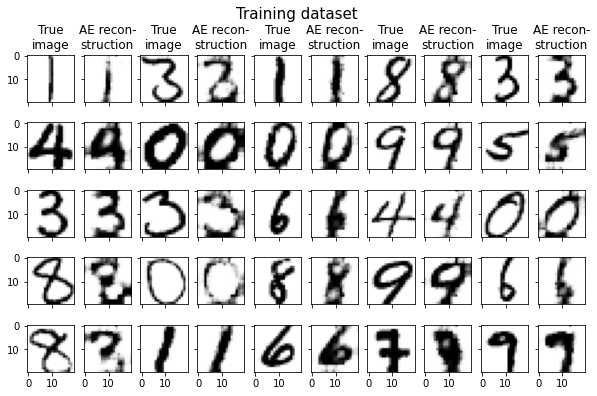

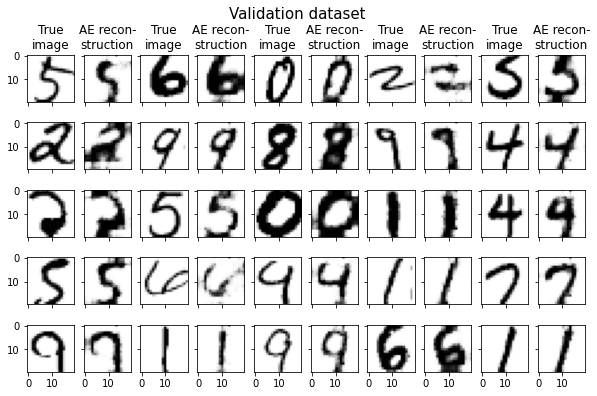

In [9]:
ae.to(device=torch.device('cpu')) 
fig, axs = plot_true_VS_reconstructed(ae, imgs_train)
fig.suptitle("Training dataset", fontsize=15)
plt.show()
fig, axs = plot_true_VS_reconstructed(ae, imgs_val)
fig.suptitle("Validation dataset", fontsize=15)
plt.show()


### Example of AE results on the training dataset

![Example of AE results on the training dataset (see AE_train_reconstruction image)](AE_val_reconstruction.png)

### Example of AE results on the validation dataset

![Example of AE results on the validation dataset (see AE_train_reconstruction image)](AE_val_reconstruction.png)

--------------------
## TODO
Analyse the results in the images above.

1. Would you say that the reconstructed images look good?
1. Now take a closer look at the bottom right pair in the training dataset example. What can you say? 

### Compress images using the Encoder part of our trained AE

--------------------
## TODO


1. Use the ``transform_images`` function defined in the cell below to compress ``train_loader_imgs`` and ``val_loader_imgs`` and store them in ``compressed_imgs_train`` and ``compressed_imgs_val``. To do so call the function with the encoder part of our AE (accessible using ``ae.encoder``)
2. We have divided by more than 10 the size of the original data, cite some obvious advantages of this compression. 
3. Recalling this [video](https://www.youtube.com/watch?v=ZCNbjpcX0yg&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=71), this other [video](https://www.youtube.com/watch?v=xjlvVfEbhz4&list=PLLssT5z_DsK_gyrQ_biidwvPYCRNGI3iv&index=74) and this [lecture](https://www.youtube.com/watch?v=5WoItGTWV54&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=16) (from 20:40 to 27:05 ) from the curriculum, what could be another application of these compressed data?

In [10]:
def transform_images(model, dataloader, device=None):
    """
    Apply ``model`` to ``dataloader`` and returns the output 
    """
    if device is None:
        device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    model.eval()
    transformed_imgs = []
    for imgs in dataloader:
        with torch.no_grad():
            imgs = imgs.to(device=device) 
            outputs = model(imgs)
            transformed_imgs.append(outputs.clone().detach())
    transformed_imgs = torch.cat(transformed_imgs)
    return transformed_imgs


ae.to(device=device)

# Keep shuffle to False here otherwise imgs won't correspond to labels anymore
train_loader_imgs = DataLoader(imgs_train, batch_size=256, shuffle=False) 
val_loader_imgs = DataLoader(imgs_val, batch_size=256, shuffle=False)

# Use the encoder part of our ae to compress our images
compressed_imgs_train = transform_images(ae.encoder, train_loader_imgs, device=device)
compressed_imgs_val = transform_images(ae.encoder, val_loader_imgs, device=device)

# Re-associate compressed images with their corresponding labels
data_compressed_train = list(zip(compressed_imgs_train, label_train))
data_compressed_val = list(zip(compressed_imgs_val, label_val))

### Classification on compressed images

In the cell below we train ``MyClassifier`` (defined in the "Modules" subsection at the beginning of this section), a classifier that takes as input a tensor `z` in the latent space (lower dimension than the image space) and find the label corresponding to the original image.

--------------------
## TODO

1. Recalling that we started from 20x20 (=400) images that were compressed into a 15 dimensional space, are you satisfied by the classification performance? 

In [11]:
epoch = 30
lr=0.001

n_labels = 10

train_loader_compressed = DataLoader(data_compressed_train, batch_size=512, shuffle=True)
val_loader_compressed = DataLoader(data_compressed_val, batch_size=512, shuffle=True)

classifier_compressed = MyClassifier(z_dim=z_dim, n_labels=n_labels)
classifier_compressed.to(device=device) 
optimizer = optim.Adam(classifier_compressed.parameters(), lr=lr)

loss_fn = nn.CrossEntropyLoss()

print(" ============== Training Classifier on compressed images ============== ")
_ = train(
    n_epochs = epoch,
    optimizer = optimizer,
    model = classifier_compressed,
    loss_fn = loss_fn,
    train_loader = train_loader_compressed,
    device=device,
)


 ============== Training Classifier on compressed images ============== 
11:24:31.972151  |  Epoch 1  |  Training loss 1.94763
11:24:33.085796  |  Epoch 5  |  Training loss 1.58331
11:24:34.462756  |  Epoch 10  |  Training loss 1.55129
11:24:35.903629  |  Epoch 15  |  Training loss 1.53892
11:24:37.562077  |  Epoch 20  |  Training loss 1.52865
11:24:39.055262  |  Epoch 25  |  Training loss 1.52422
11:24:40.506062  |  Epoch 30  |  Training loss 1.51945


In [12]:
print(" ============== Classification on compressed images ============== ")
_ = compute_accuracy(classifier_compressed,train_loader_compressed)
print("Training")
_ = compute_accuracy(classifier_compressed, train_loader_compressed)
print("Validation")
_ = compute_accuracy(classifier_compressed, val_loader_compressed)

 ============== Classification on compressed images ============== 
Accuracy: 0.4690
Training
Accuracy: 0.4690
Validation
Accuracy: 0.4677


### Reconstruct images using the Decoder part of our trained AE

--------------------
## TODO


1. Use the ``transform_images`` function defined earlier to reconstruct ``train_loader_compressed_imgs`` and ``val_loader_compressed_imgs`` and store them in ``reconstructed_imgs_train`` and ``reconstructed_imgs_val``. To do so call the function with the decoder part of our AE (accessible using ``ae.decoder``)

In [13]:
# Keep shuffle to False here otherwise imgs won't correspond to labels anymore
train_loader_compressed_imgs = DataLoader(compressed_imgs_train, batch_size=256, shuffle=False)
val_loader_compressed_imgs = DataLoader(compressed_imgs_val, batch_size=256, shuffle=False)    

# Use the decoder part of our ae to reconstruct our compressed images
reconstructed_imgs_train = transform_images(ae.decoder, train_loader_compressed_imgs, device=device)
reconstructed_imgs_val = transform_images(ae.decoder, val_loader_compressed_imgs, device=device)

# Re-associate reconstructed images with their corresponding labels
data_reconstructed_train = list(zip(reconstructed_imgs_train, label_train))
data_reconstructed_val = list(zip(reconstructed_imgs_val, label_val))

### Classification on reconstructed images VS true images

In the cell below we train 2 instances of ``LeNet5`` (defined in ``utils.py``), a regular classifier that takes an image and find its corresponding label. The first instance is trained on the reconstructed images and the second one is trained on the original images

In the next cell we evaluate the performance of our classifiers.

--------------------
## TODO

1. Compare the performance of the 2 models. Are you satisfied with the classification on the reconstructed images?
2. If so, can we throw away our original images (and keep only our trained AE and compressed images)? 

In [14]:
epoch = 30
lr=0.001

print(" ============== Training Classifier on reconstructed images ============== ")

torch.manual_seed(seed)

train_loader_reconstructed = DataLoader(data_reconstructed_train, batch_size=512, shuffle=True)
val_loader_reconstructed = DataLoader(data_reconstructed_val, batch_size=512, shuffle=True)

classifier_reconstructed = LeNet5(n_labels=n_labels)
classifier_reconstructed.to(device=device) 
optimizer = optim.Adam(classifier_reconstructed.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

train(
    n_epochs = epoch,
    optimizer = optimizer,
    model = classifier_reconstructed,
    loss_fn = loss_fn,
    train_loader = train_loader_reconstructed,
)

print(" ============== Training Classifier on true images ============== ")

torch.manual_seed(seed)

train_loader_true = DataLoader(data_train, batch_size=512, shuffle=True)
val_loader_true = DataLoader(data_val, batch_size=512, shuffle=True)

classifier_true = LeNet5(n_labels=n_labels)
classifier_true.to(device=device) 
optimizer = optim.Adam(classifier_true.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

_ = train(
    n_epochs = epoch,
    optimizer = optimizer,
    model = classifier_true,
    loss_fn = loss_fn,
    train_loader = train_loader_true,
)


 ============== Training Classifier on reconstructed images ============== 
11:24:41.686343  |  Epoch 1  |  Training loss 1.35600
11:24:43.248962  |  Epoch 5  |  Training loss 0.63184
11:24:45.182659  |  Epoch 10  |  Training loss 0.60098
11:24:47.117725  |  Epoch 15  |  Training loss 0.58251
11:24:49.060644  |  Epoch 20  |  Training loss 0.57160
11:24:51.054959  |  Epoch 25  |  Training loss 0.56220
11:24:52.995328  |  Epoch 30  |  Training loss 0.55363
 ============== Training Classifier on true images ============== 
11:24:57.435587  |  Epoch 1  |  Training loss 1.22509
11:25:15.414434  |  Epoch 5  |  Training loss 0.80680
11:25:38.182236  |  Epoch 10  |  Training loss 0.77409
11:26:00.707433  |  Epoch 15  |  Training loss 0.54440
11:26:22.959012  |  Epoch 20  |  Training loss 0.52807
11:26:45.373180  |  Epoch 25  |  Training loss 0.52311
11:27:07.744120  |  Epoch 30  |  Training loss 0.51786


In [15]:
print(" ============== Classification on reconstructed images ============== ")
print("Training")
_ = compute_accuracy(classifier_reconstructed, train_loader_reconstructed)
print("Validation")
_ = compute_accuracy(classifier_reconstructed, val_loader_reconstructed)

print(" ============== Classification on true images ============== ")
print("Training")
_ = compute_accuracy(classifier_true, train_loader_true)
print("Validation")
_ = compute_accuracy(classifier_true, val_loader_true)

 ============== Classification on reconstructed images ============== 
Training
Accuracy: 0.7791
Validation
Accuracy: 0.7613
 ============== Classification on true images ============== 
Training
Accuracy: 0.7771
Validation
Accuracy: 0.7632
